In [3]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
img_list=[]
files = os.listdir("C:/Users/pc/Desktop/aptosDataset/train_images")
for i in files[::]:
    image = cv2.imread(f"C:/Users/pc/Desktop/aptosDataset/train_images/{i}")
    image = cv2.resize(image,(400,400))
    image = image[:,:,1]
    kopya = image.copy()
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thold = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kenar = cv2.findContours(thold.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kenar = kenar[0][0]
    kenar = kenar[:,0,:]
    x1 = tuple(kenar[kenar[:,0].argmin()])[0]
    y1 = tuple(kenar[kenar[:,1].argmin()])[1]
    x2 = tuple(kenar[kenar[:,0].argmax()])[0]
    y2 = tuple(kenar[kenar[:,1].argmin()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*4//50
    kopya2 = image.copy()
    if x2-x1 > 100 and y2-y1 > 100:
        kopya2 = kopya2[y1+y:y2-y,x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    clahe = cv2.createCLAHE(clipLimit = 5.0,tileGridSize=((8,8)))
    cl = clahe.apply(kopya2)
    med_resim = cv2.medianBlur(kopya2,3)
    arka_plan = cv2.medianBlur(kopya2,33)
    maske = cv2.addWeighted(med_resim,1,arka_plan,-1,255)
    maske_resim = cv2.bitwise_and(maske,med_resim)
    img_list.append(maske_resim)
    

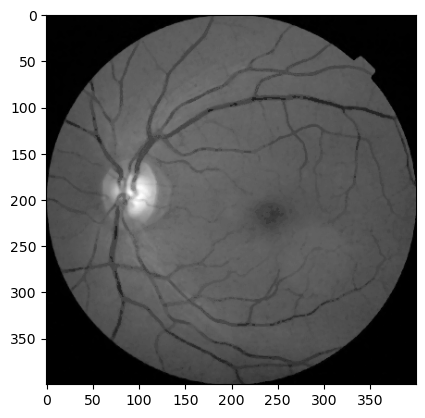

In [5]:
plt.imshow(img_list[15],cmap="gray")

In [6]:
df = pd.read_csv("C:/Users/pc/Desktop/aptosDataset/train.csv",sep =",")

In [7]:
df["diagnosis"]

0       2
1       4
2       1
3       0
4       0
       ..
3657    2
3658    0
3659    2
3660    0
3661    2
Name: diagnosis, Length: 3662, dtype: int64

In [8]:
y_train = pd.get_dummies(df["diagnosis"]).values.astype(int)

In [9]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [10]:
y_train_son = np.ones(y_train.shape,dtype="uint0")

In [11]:
y_train_son[:,4] = y_train[:,4]

In [12]:
y_train_son

array([[1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       ...,
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0]], dtype=uint64)

In [13]:
for i in range(3,-1,-1):
    y_train_son[:,i]=np.logical_or(y_train[:,i],y_train_son[:,i+1])


In [14]:
y_train_son

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint64)

In [15]:
x_train = np.array(img_list)

In [16]:
x_train.shape

(3662, 400, 400)

In [17]:
y_train_son.shape

(3662, 5)

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train_son,test_size=0.15,random_state=42,shuffle = True)

In [19]:
x_train = np.expand_dims(x_train, axis=-1)

In [20]:
x_train.shape

(3112, 400, 400, 1)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = True , vertical_flip = True,rescale=1/255)
data_generator = datagen.flow(x_train,y_train,batch_size=32,seed = 42)

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [35]:
from tensorflow.keras.layers import BatchNormalization

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(400,400,1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [40]:
optimizer = Adam(learning_rate=0.0000001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(data_generator,epochs=5)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7421 - loss: 50.1195
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.7643 - loss: 53.4106
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.7759 - loss: 49.3055
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.7964 - loss: 51.1442
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.7810 - loss: 54.3993
